# Introduction

Histopathologic cancer detection plays a critical role in the early diagnosis and treatment of cancer, significantly impacting patient outcomes. One of the most promising avenues for enhancing the accuracy and efficiency of cancer detection is through the application of deep learning techniques. In this context, Kaggle hosts an exciting competition aimed at harnessing the power of artificial intelligence to identify metastatic cancer in small image patches extracted from larger digital pathology scans.

The competition revolves around a dataset derived from the PatchCamelyon (PCam) benchmark dataset, with slight modifications to remove duplicate images. PCam, renowned for its substantial size, accessibility, and ease of use, presents an ideal platform for both seasoned machine learning practitioners and those looking to embark on their deep learning journey. As the competition description aptly notes, PCam offers a unique opportunity to make a tangible impact on histopathologic cancer detection through data-driven solutions.

The Kaggle link to the challenge can be found here: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

The dataset contains:

    1. test images with file name as the ID.
    2. train images with file name as the ID.
    3. train_labels.csv with two features.
        - ID linking train image to row.
        - Label binary classification acknowledging presence of cancer.



The run this locally it is recommended to first run "create_venv.sh". This will create a python3 virtual environment when running in Linux. Other steps will need to be taken if using MacOSx or Windows.

In [38]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install scikit-image

In [39]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from skimage import io


# EDA

The train_labels.csv data is quite clean and contains an image id along with the label. No null counts were found and no cleaning is required.

In [40]:
df = pd.read_csv("train_labels.csv")

print(df.head())

print("\n----- Null counts -----")
null_counts = df.isna().sum()
print(null_counts)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

----- Null counts -----
id       0
label    0
dtype: int64


The distribution of tumor or no tumor is inbalanced. Yet, there is so much data available ~210000 images this will have little impact on this lab as for time's sake we will take a subset of these images for the model to save on training time.

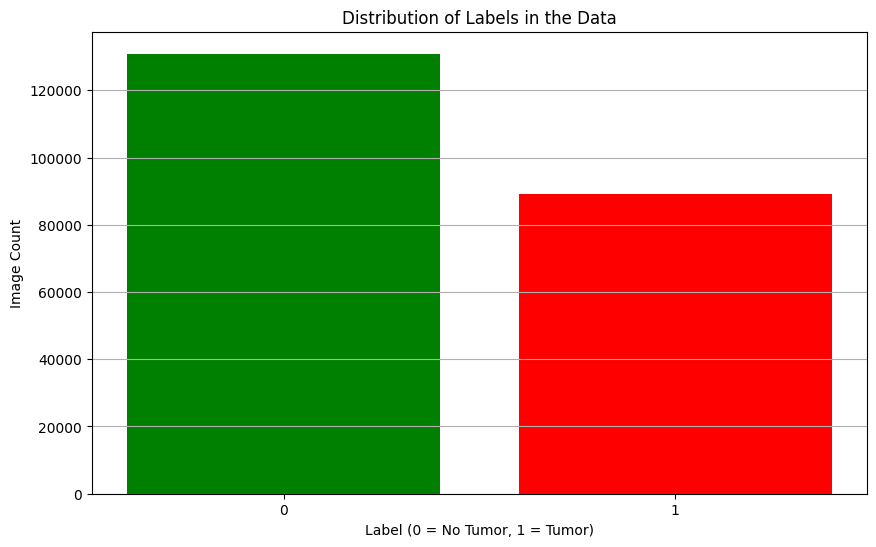

In [41]:
labels, counts = zip(*Counter(df["label"]).items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=["green", "red"])
plt.xlabel("Label (0 = No Tumor, 1 = Tumor)")
plt.ylabel("Image Count")
plt.title("Distribution of Labels in the Data")
plt.xticks(labels)
plt.grid(axis='y')
plt.show()

Looking at some of the images with either of the two labels. There is no noteable difference between the two categories.

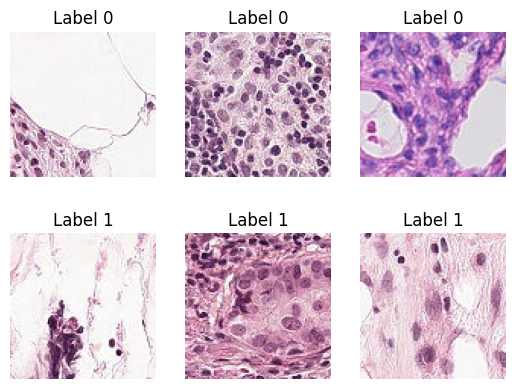

In [42]:
num_images_to_display = 3

df["path"] = df["id"].apply(lambda x: os.path.join("train", str(x) + ".tif"))
images_with_label_0 = df[df["label"] == 0]
images_with_label_1 = df[df["label"] == 1]

for i in range(num_images_to_display):
    image = plt.imread(images_with_label_0["path"].iloc[i])

    plt.subplot(2, num_images_to_display, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 0")

for i in range(num_images_to_display):
    image = plt.imread(images_with_label_1["path"].iloc[i])

    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label 1")


plt.show()


It seem as if all these images are of the same width, height and channel count. But check these are all the same is worth while.

In [43]:
unique_dimensions = set()
random_indices = np.random.randint(0, len(df), 1000)
for index in random_indices:
    image = io.imread(df["path"].iloc[index])
    image_height, image_width, image_channels = image.shape
    unique_dimensions.add((image_height, image_width, image_channels))

print(f"Unique dimension: {unique_dimensions}")
print(f"Image Height: {image_height} pixels")
print(f"Image Width: {image_width} pixels")
print(f"Number of Channels (Depth): {image_channels}")

Unique dimension: {(96, 96, 3)}
Image Height: 96 pixels
Image Width: 96 pixels
Number of Channels (Depth): 3


To ensure we gain the benefit of exploring different model changes we can take a subset of all our samples by taking 10000 images with label 0 and 10000 images with label 1. We can then use this as our training data and split it into training and test data.

In [44]:
df["label"] = df["label"].astype(str)
df_0 = df[df["label"] == "0"].sample(10000, random_state=42)
df_1 = df[df["label"] == "1"].sample(10000, random_state=42)
df_subset = pd.concat([df_0, df_1], ignore_index=True)

train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(df_subset["path"], df_subset["label"], test_size=0.2, random_state=42)

The class ImageDataGenerator is a Keras library used with data augmentation and preprocessing of image data with deep learning tasks. We gain the following benefits:
- Augmenting the training data with rotations, width and height shifts, shearing, zooming and flipping reduces the changes we overfit our data. 
- Pixel scaling is done to normalize the pixel data giving a boost to the covergence of the training process. 
- Efficient loading allows us to work directly directories of images or dataframe.

We will use the directory load method but will need to split our chosen subset of data into a train folder and test folder. So we will copy these images to these new folders.

In [45]:
# Create directory called train_data and copy the training data into it
train_dir = "train_data"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
os.makedirs(os.path.join(train_dir, "0"))
os.makedirs(os.path.join(train_dir, "1"))
for file_path, label in zip(train_file_paths, train_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(train_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(train_dir, "1", name))

# Create directory called test_data and copy the test data into it
test_dir = "test_data"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)
os.makedirs(os.path.join(test_dir, "0"))
os.makedirs(os.path.join(test_dir, "1"))
for file_path, label in zip(test_file_paths, test_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(test_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(test_dir, "1", name))

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# DModel Architecture

We have image data with an image height and width of 96 and 3 image channels (RGB). We wish to perform binary classification on the data. Some of the reasoning for the model below are as stated.

- Sigmoid Activation in Output Layer: The model uses a sigmoid activation function in the output layer, which is suitable for binary classification. Sigmoid squashes the output to the range [0, 1], making it interpretable as a probability. We can threshold the output at 0.5 to make binary predictions.

- Binary Cross-Entropy Loss: It's common to use binary cross-entropy loss with sigmoid activation for binary classification tasks. Binary cross-entropy measures the dissimilarity between the predicted probabilities and the actual binary labels.

- Convolutional Layers: Convolutional layers are effective at learning hierarchical features from images. They can capture low-level features like edges and high-level features like shapes, which are important for distinguishing objects or patterns in binary classification.

- Max-Pooling Layers: Max-pooling layers help reduce the spatial dimensions of the feature maps while retaining the most important information. This down-sampling can help the model focus on the most discriminative features.

- Batch Normalization: Batch normalization helps in stabilizing and accelerating the training process. It normalizes the activations of the previous layer, which can prevent issues like vanishing gradients and improve convergence.

- Dropout: The dropout layer with a rate of 0.5 is included to prevent overfitting. During training, dropout randomly deactivates a fraction of neurons, forcing the model to learn more robust features.

- Flatten Layer: After the convolutional layers, the Flatten layer is used to convert the 2D feature maps into a 1D vector, which is necessary for connecting to the dense layers for classification.

- Dense Layers: The model includes fully connected dense layers, which can capture complex relationships in the data. The first dense layer with 64 units provides the model with expressive power, and the final dense layer with a single neuron outputs the binary classification result.

There are handful hyperparameters that could be modified in this model.

- Learning Rate: Learning rate controls the step size during optimization. Higher learning rates can lead to faster convergence but may risk overshooting the optimal solution. Lower learning rates may be more stable but require longer training.

- Optimizer: The optimizer algorithm affects how the model's weights are updated during training. Adam is a popular choice and often works well in practice. RMSprop and SGD (Stochastic Gradient Descent) are also viable options. Each optimizer has its own set of hyperparameters (e.g., momentum for SGD) that we can tune.

- Number of Epochs: The number of training epochs determines how many times the model sees the entire training dataset. Too few epochs may result in underfitting, while too many may lead to overfitting.

- Batch Size: The batch size defines how many samples are processed in each forward and backward pass. Smaller batch sizes may lead to slower training but can help generalize better. Larger batch sizes may speed up training but could result in overfitting.

- Dropout Rate: Dropout is a regularization technique that helps prevent overfitting. The dropout rate determines the probability of dropping out a neuron during training. We can use values between 0 and 1.


Our first model we'll use the following hyperparameters:

- Learning Rate = 0.001
- Optimizer = RMSprop
- Epoch Number = 10
- Batch Size = 32
- Dropout Rate = 0.5


In [46]:
# Hyperparameters
learning_rate = 0.001
optimizer = RMSprop(learning_rate=learning_rate)
training_epochs = 10
batch_size = 32
dropout_rate = 0.5

model1 = Sequential()
pool_size = (3, 3)
filter_size = (3, 3)

# Convolutional layers
model1.add(Conv2D(16, filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model1.add(Conv2D(16, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

model1.add(Conv2D(32, filter_size, activation='relu'))
model1.add(Conv2D(32, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

model1.add(Conv2D(64, filter_size, activation='relu'))
model1.add(Conv2D(64, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

# Convert to 1D vector
model1.add(Flatten())

# Classification layers
model1.add(Dense(64, activation='sigmoid'))
model1.add(Dropout(dropout_rate))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=test_generator.n//test_generator.batch_size
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=training_epochs,
    validation_data=test_generator,
    validation_steps=validation_steps_per_epoch
)

Epoch 1/10
500/500 [==============================] - 81s 161ms/step - loss: 0.5148 - accuracy: 0.7582 - val_loss: 0.4543 - val_accuracy: 0.7868
Epoch 2/10
500/500 [==============================] - 83s 165ms/step - loss: 0.4608 - accuracy: 0.7955 - val_loss: 0.4746 - val_accuracy: 0.7820
Epoch 3/10
500/500 [==============================] - 93s 186ms/step - loss: 0.4396 - accuracy: 0.8039 - val_loss: 0.7653 - val_accuracy: 0.6557
Epoch 4/10
500/500 [==============================] - 98s 196ms/step - loss: 0.4290 - accuracy: 0.8104 - val_loss: 0.4723 - val_accuracy: 0.7747
Epoch 5/10
500/500 [==============================] - 99s 197ms/step - loss: 0.4167 - accuracy: 0.8138 - val_loss: 0.5771 - val_accuracy: 0.7078
Epoch 6/10
500/500 [==============================] - 105s 211ms/step - loss: 0.4079 - accuracy: 0.8188 - val_loss: 0.8768 - val_accuracy: 0.5867
Epoch 7/10
500/500 [==============================] - 102s 203ms/step - loss: 0.3948 - accuracy: 0.8264 - val_loss: 0.6647 - val_

Our second model we'll use the following hyperparameters:

- Learning Rate = 0.01
- Optimizer = SGD
- Epoch Number = 10
- Batch Size = 32
- Dropout Rate = 0.25

In [47]:
# Hyperparameters
learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate)
training_epochs = 10
batch_size = 32
dropout_rate = 0.25

model2 = Sequential()
pool_size = (3, 3)
filter_size = (3, 3)

# Convolutional layers
model2.add(Conv2D(16, filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model2.add(Conv2D(16, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(32, filter_size, activation='relu'))
model2.add(Conv2D(32, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

# Convert to 1D vector
model2.add(Flatten())

# Classification layers
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(dropout_rate))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=test_generator.n//test_generator.batch_size
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=training_epochs,
    validation_data=test_generator,
    validation_steps=validation_steps_per_epoch
)

Epoch 1/10
500/500 [==============================] - 113s 223ms/step - loss: 0.5404 - accuracy: 0.7338 - val_loss: 0.7285 - val_accuracy: 0.5132
Epoch 2/10
500/500 [==============================] - 111s 222ms/step - loss: 0.4854 - accuracy: 0.7767 - val_loss: 0.6263 - val_accuracy: 0.6647
Epoch 3/10
500/500 [==============================] - 106s 212ms/step - loss: 0.4689 - accuracy: 0.7859 - val_loss: 0.4275 - val_accuracy: 0.8085
Epoch 4/10
500/500 [==============================] - 112s 223ms/step - loss: 0.4475 - accuracy: 0.7968 - val_loss: 0.4990 - val_accuracy: 0.7692
Epoch 5/10
500/500 [==============================] - 109s 218ms/step - loss: 0.4458 - accuracy: 0.7971 - val_loss: 0.6158 - val_accuracy: 0.6740
Epoch 6/10
500/500 [==============================] - 112s 224ms/step - loss: 0.4361 - accuracy: 0.8040 - val_loss: 0.6377 - val_accuracy: 0.6808
Epoch 7/10
500/500 [==============================] - 111s 223ms/step - loss: 0.4328 - accuracy: 0.8043 - val_loss: 0.5620 -

# Results and Analysis

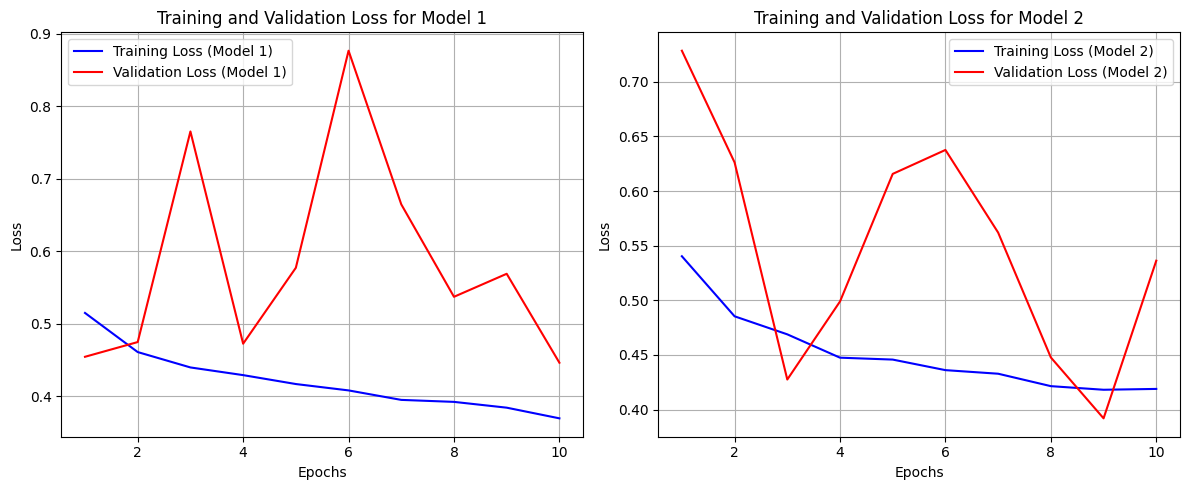

In [56]:
# Access the training history from the 'history' object of each model
training_loss1 = model1.history.history['loss']
validation_loss1 = model1.history.history['val_loss']
training_loss2 = model2.history.history['loss']
validation_loss2 = model2.history.history['val_loss']
epochs = range(1, len(training_loss1) + 1)

# Create a subplot for training loss for Model 1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss1, label='Training Loss (Model 1)', color='blue')
plt.plot(epochs, validation_loss1, label='Validation Loss (Model 1)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Model 1')
plt.grid(True)

# Create a subplot for training loss for Model 2
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss2, label='Training Loss (Model 2)', color='blue')
plt.plot(epochs, validation_loss2, label='Validation Loss (Model 2)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Model 2')
plt.grid(True)

plt.tight_layout()
plt.show()


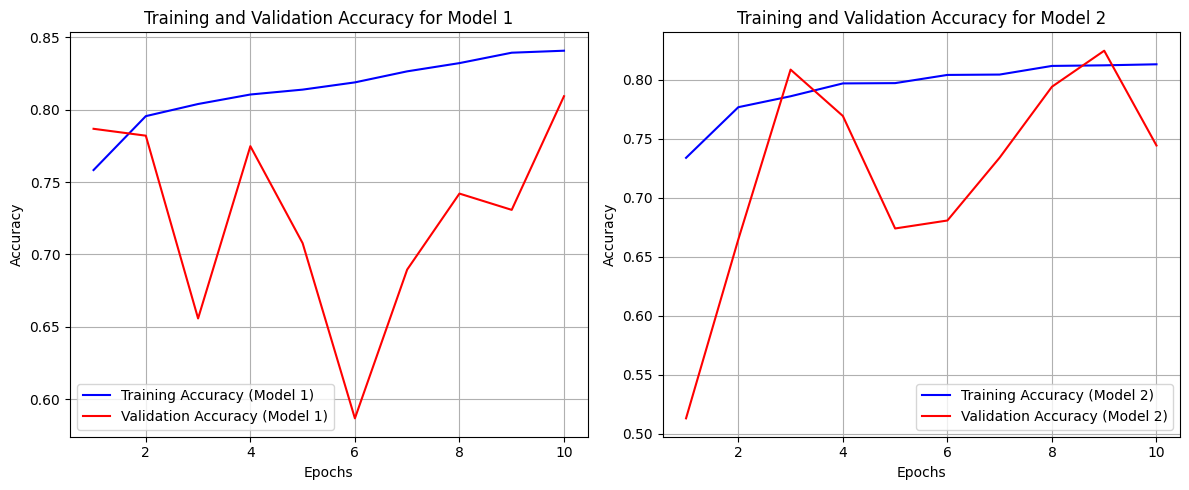

In [55]:
# Access the training history from the 'history' object of each model
training_acc1 = model1.history.history['accuracy']
validation_acc1 = model1.history.history['val_accuracy']
training_acc2 = model2.history.history['accuracy']
validation_acc2 = model2.history.history['val_accuracy']

# Create an array of epochs for the x-axis
epochs = range(1, len(training_acc1) + 1)

# Create a subplot for training accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_acc1, label='Training Accuracy (Model 1)', color='blue')
plt.plot(epochs, validation_acc1, label='Validation Accuracy (Model 1)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for Model 1')
plt.grid(True)

# Create a subplot for validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc2, label='Training Accuracy (Model 2)', color='blue')
plt.plot(epochs, validation_acc2, label='Validation Accuracy (Model 2)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for Model 2')
plt.grid(True)

plt.tight_layout()
plt.show()


In [67]:
submission_df = pd.DataFrame(columns=["id", "label"])

test_file_paths = []
for root, _, files in os.walk("test"):
    for name in files:
        test_file_paths.append(os.path.join(root, name))

for file in test_file_paths:
    image = io.imread(file)
    id = file.split("/")[-1].split(".")[0]
    prediction = model1.predict(image.reshape(1, 96, 96, 3), verbose=0)

    # Use len(submission_df) to determine the index
    row = {"id": id, "label": 0 if prediction < 0.5 else 1}
    submission_df.loc[len(submission_df)] = row
    print(f"Progress: {len(submission_df)}/{len(test_file_paths)}", end="\r")


1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

In [ ]:

predictions = np.array(predictions)
test_df["label"] = predictions

# Conclusion